We're going to put together a pretty simple SNN to do image identification of the Fashion mnist dataset, which consists of 
28x28 greyscale images of clothing of 10 classifications: t-shirt, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot. 


In [1]:
#!pip install git+https://github.com/ORNL/superneuromat

In [2]:
from superneuromat.neuromorphicmodel import NeuromorphicModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Load in training data
df = pd.read_csv("archive/fashion-mnist_train.csv")

#Initialize our model
model = NeuromorphicModel()

#Create our output neurons, set threshold very high so that we control when they spike during training.
outputNeurons = []
while (len(outputNeurons) < 10):
    outputNeurons.append(model.create_neuron(threshold=10000))

#Create our input neurons, one for each pixel of the image resolution.
while (model.num_neurons < 794):
    input = model.create_neuron()
    #Connect our input neuron to output neurons
    for output in outputNeurons:
        #Randomize initial weight
        weight = (np.random.rand()*2 - 1)*0.00001
        #Make a synapse connecting the input to the output
        model.create_synapse(input, output, weight=weight,
                             enable_stdp=True, delay=1)

#loop through our dataset
timestep = 0
for row in df.itertuples(index=False):
    count = 0
    for value in row:
        #The first value in the row is the label, 0-9, which corresponds to our 10 input neurons. Add a spike that will exceed the threshold
        if (count == 0):
            model.add_spike(timestep + 1, value, 10001.0)
        else:
            #Otherwise its a pixel, which we'll feed in as a spike to its corresponding input neuron.
            if (value > 0):
                model.add_spike(timestep, count + 9, value/255)
        count += 1
    timestep += 1


In [13]:
#Set up our stdp, only one timestep because we only want it looking at the results of what our input layer does to our output layer
model.stdp_setup(time_steps=1, Apos=[0.0001], Aneg=[
                 0.0000001], negative_update=True, positive_update=True)
model.setup()

#Simulate
print(timestep)
model.simulate(time_steps=timestep)

10000


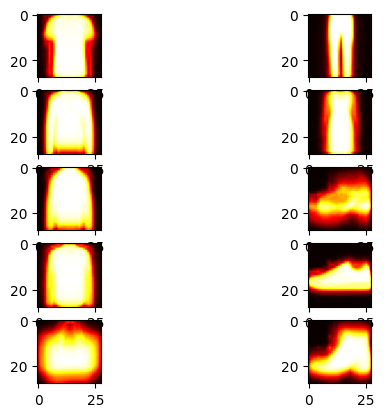

In [12]:
#Copy over our weights
post_weights = model._weights.copy()
#Get our input neuron weights
input_weights = post_weights[-784:, :]

#Set up a 5x2 display to show our weights
fig, ax = plt.subplots(nrows=5, ncols=2)
item = 0

#Turn all of our weights into images
for row in ax:
    for col in row:
        col.imshow(input_weights[:, item].reshape((28, 28)), cmap="hot")
        item += 1

#Save those weights and their image
plt.savefig("post_weights.png")
np.savetxt("digits_weights.csv", input_weights, delimiter=",")

In [10]:
#No way to clear spikes from a model, so we need to make a new one.
model2 = NeuromorphicModel()

#We're no longer in control of when our outputs spike, so let's put some weights on them so they don't spike all the time.
outputNeurons = []
thresholds = [3, 1, 3, 2, 4, 0, 4, 1, 2, 2]

#Make our output neurons
for value in thresholds:
    outputNeurons.append(model2.create_neuron(threshold=value))

#Make our input neurons
while (model2.num_neurons < 794):
    input = model2.create_neuron()
    #Connect the inputs to the outputs, do not enable stdp, weight doesn't matter here, we're changing it later.
    for output in outputNeurons:
        model2.create_synapse(input, output, weight=0.0,
                              enable_stdp=False, delay=1)

In [7]:
#Read in our testing dataset
df2 = pd.read_csv("archive/fashion-mnist_test.csv")

#Useful to keep track of your answers in case we decide to use them later.
solution_neurons = []
#Loop through the data again
timestep = 0
for row in df2.itertuples(index=False):
    count = 0
    for value in row:
        #Save our correct answers
        if (count == 0):
            solution_neurons.append(value)
        else:
            #Or add a spike
            if (value > 0):
                model2.add_spike(timestep, count + 9, value/255)
        count += 1
    timestep += 1


In [14]:
#Copy our synaptic weights
model2.synaptic_weights = model.synaptic_weights
#Set up our model
model2.setup()
#Simulate
model2.simulate(time_steps=timestep)